# 🤖 ASR系列-微調-Whisper模型-LoRA策略

> 使用 Peft 訓練框架、LoRA 策略微調 Whisper-tiny 模型，專屬於你的第一堂微調ASR模型實戰課程
> 日期：2025/10/08-0930

<a href="https://www.tenlong.com.tw/products/9786264142915"><img src="https://github.com/openpipe/art/raw/main/assets/Header_separator.png" height="5"></a>

## 👨‍💻 作者資源與聯絡方式

### 📚 深度學習專書
**📖 《LangGraph 實戰開發 AI Agent 全攻略》** - 我的最新技術著作
深入探討 LangGraph、Agentic AI System 等前沿技術
**[立即購買](https://www.tenlong.com.tw/products/9786264142915)**

### 🌐 社群媒體與技術交流
如果您有任何疑問或想要進一步交流，歡迎透過以下管道聯絡：

* **📖 技術專書**： [購買我的 LangGraph 實戰開發 AI Agent 全攻略](https://www.tenlong.com.tw/products/9786264142915)
* **💻 GitHub**： [我的開源專案](https://github.com/Heng-xiu)
* **🤗 Hugging Face**： [我的模型與資料集](https://huggingface.co/Heng666)
* **✍️ 部落格**： [技術文章分享](https://r23456999.medium.com/)

感謝大家的支持！期待與更多 AI 技術愛好者交流討論 🚀

<div class="align-center">
  <a href="https://ko-fi.com/hengshiousheu"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a>
</div>

<a href="https://www.tenlong.com.tw/products/9786264142915"><img src="https://github.com/openpipe/art/raw/main/assets/Header_separator.png" height="5"></a>



#第一章節、微調的必要性

OpenAI 的 Whisper 是一款先進的自動語音辨識（ASR）系統，透過龐大的多語言音訊與轉錄資料集，展現出令人驚豔的即開即用轉錄能力。如圖 1 所示，Whisper 的表現深受其原始訓練資料分佈的影響，能夠在多樣化的情境中提供穩健的轉錄效果。

然而，當您的應用場景涉及專業詞彙、資源不足的語言，或是預訓練時未充分涵蓋的獨特音訊特徵時，微調將成為提升效能的關鍵利器。透過將模型調整至您的特定資料集——無論是針對特定領域的術語、獨特的音訊特性，或是多樣化的講者族群——微調能顯著降低詞錯率（WER），大幅提升轉錄的精確度與可靠性。

![img](https://www.diabolocom.com/wp-content/uploads/multilingual-speech-recognition.jpg)

圖 1：Whisper 訓練資料集概覽（Radford et al., 2022）

雖然 Whisper 已針對 98 種語言進行預訓練，但其在 41 種資源較少的語言上（詞錯率高於 50%）的表現明顯下降，這凸顯了針對低資源方言或特定應用進行微調的必要性。透過有針對性的微調，Whisper 能有效彌補效能差距，確保在專業化或資源不足的場景中，依然能夠提供精準且高效的語音辨識表現。

## 1.1-教學流程：微調 Whisper 以優化對話式語音辨識

本教學將逐步指導您如何在中文資料集上，對 OpenAI 的 Whisper tiny模型進行微調，以提升其語音轉文字（STT）效能。我們選用了來自 PolyAI/minds 的中文語音子集，

本教學涵蓋以下核心步驟：  

1. **準備資料集與環境設定** - 設定好環境，載入 minds 子資料集。
2. **資料預處理與格式化** - 清理音訊（篩選長度、轉換特徵）、轉換資料（批次處理、整理格式）。
3. **載入與調整模型** - 拿到預訓練 Whisper，設定 LoRA 參數。
4. **執行微調與監控** - 開始訓練，盯著過程看。
5. **評估與驗證** - 用 WER 檢查成果。

透過這些步驟，您將能夠針對特定語言或對話場景優化 Whisper 模型，顯著提升其在專業應用中的語音辨識精確度。



---



# 第二章：環境建置與前置準備
在我們開始微調 Whisper 之前，首先要確保我們的開發環境已經準備就緒。一個穩定且配置正確的環境是成功訓練模型的第一步。

> GPU 啟用： 請確保您的 Colab Notebook 已啟用 GPU。點擊菜單欄的 執行階段 (Runtime) -> 變更執行階段類型 (Change runtime type)，然後在 硬體加速器 (Hardware accelerator) 中選擇 GPU。

##2.1 首先，來登入 HuggingFace

本章節我們先確認在本實驗環境中，可以獲取到 HuggingFace 資源，包含下載資料集、模型等操作

您可以在 Hugging Face Hub 中找到您的 [Hugging Face token](https://huggingface.co/login?next=%2Fsettings%2Ftokens)


In [1]:
from google.colab import userdata
from huggingface_hub import HfApi

HF_TOKEN = userdata.get("HF_TOKEN")

api = HfApi(token=HF_TOKEN)
username = api.whoami()['name']
print(username)

Heng666


## 2.2 GPU 驅動與 CUDA 支援確認

LLM 的訓練需要大量的計算資源，幾乎必須仰賴 GPU (Graphics Processing Unit)。因此，確認您的環境是否正確偵測到 GPU 並支援 CUDA 是至關重要的一步。

CUDA 是 NVIDIA 提供的平行運算平台和程式設計模型，允許軟體使用 GPU 進行通用計算。PyTorch (一個流行的深度學習框架) 透過 CUDA 來利用 NVIDIA GPU 的運算能力。

請執行以下 Python 程式碼，檢查您的 PyTorch 環境是否已正確偵測到 CUDA：

In [2]:
# 3.3.1 檢查 PyTorch 是否偵測到 CUDA
import torch

print(f"PyTorch 是否支援 CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"目前使用的 CUDA 裝置名稱: {torch.cuda.get_device_name(0)}")
    print(f"CUDA 裝置數量: {torch.cuda.device_count()}")
    # 可以進一步檢查 CUDA 版本
    print(f"PyTorch 編譯的 CUDA 版本: {torch.version.cuda}")
    # 執行 nvidia-smi (僅限 Linux/Windows 終端機，Colab 可直接執行)
    # !nvidia-smi
else:
    print("警告：未偵測到 CUDA。模型訓練將在 CPU 上運行，速度會非常慢。")
    print("請檢查您的 GPU 驅動程式安裝、CUDA Toolkit 設定以及 PyTorch 的 CUDA 支援。")

PyTorch 是否支援 CUDA: True
目前使用的 CUDA 裝置名稱: Tesla T4
CUDA 裝置數量: 1
PyTorch 編譯的 CUDA 版本: 12.6


> 【重要提醒】：如果 torch.cuda.is_available() 回傳 False，您可能需要：

確認您的電腦有 NVIDIA GPU。

安裝正確版本的 NVIDIA 顯示卡驅動程式。

安裝與您 PyTorch 版本相容的 CUDA Toolkit。

對於 Colab 用戶，請再次確認您已在執行階段中選擇了 GPU。

#第三章、處理語音資料

##3.1 資料載入：準備語音轉文字資料集

本節將指導您從 Hugging Face Datasets Hub 載入語音轉文字資料集，以進行後續的 Whisper 模型微調。我們將以[PolyAI/minds14](huggingface.co/datasets/polyai/minds14/viewer/zh-cn)為例，並確保所有音訊檔案統一重新取樣至 16 kHz，以符合 Whisper 模型的輸入要求，提升資料一致性與模型訓練效率。


In [3]:
!pip install --quiet datasets==3.6.0
!pip install --quiet torchcodec==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.6 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset, Audio

minds = load_dataset("PolyAI/minds14", name="zh-CN", split="train")
minds = minds.cast_column("audio", Audio(sampling_rate=16000))

README.md: 0.00B [00:00, ?B/s]

zh-CN/train-00000-of-00001.parquet:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/502 [00:00<?, ? examples/s]

### 3.1.1 來看看資料集的樣子

我們先來聽聽資料集裡的一個音訊樣本，順便檢查它的長度跟元數據，然後畫個圖，看看訓練跟測試資料的音訊長度分佈，這樣能更清楚資料的狀況，為之後的微調做好準備！


In [5]:
def format_seconds(seconds_input):
    """
    Turn a number of seconds (possibly fractional) into a compact string,
    omitting zero-value day/hour/minute units, and always showing seconds (with
    up to millisecond precision, dropping trailing zeros).
    """
    remaining = float(seconds_input)
    parts = []
    for label, unit_secs in (("d", 86400), ("h", 3600), ("m", 60)):
        qty, remaining = divmod(remaining, unit_secs)
        if qty >= 1:
            parts.append(f"{int(qty)}{label}")
    parts.append(f"{remaining:.3f}s")

    return " ".join(parts)

您可以透過將 `sample_id` 變數變更為資料集中的任何有效索引來收聽其他範例：

In [6]:
from datasets import Audio
import IPython.display as ipd

sample_id = 0
example = minds[sample_id]

audio_array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

ipd.display(ipd.Audio(audio_array, rate=sampling_rate))

print(f"Duration: {format_seconds(audio_array.shape[0]/sampling_rate)}")

Duration: 7.765s


### 3.1.2 整理資料：讓音訊和語句符合標準

接下來，我們要來整理資料集，確保音訊和語句都符合 Whisper 的要求！具體來說，我們會保留音訊長度在 1 秒到 30 秒之間的片段，然後把語句的 token 長度超過 448 的部分刪掉。這兩個步驟超重要：一個是處理音訊，一個是處理語句。

為什麼要這樣做？因為 Whisper 在訓練時只用 30 秒以內的音訊片段，超過這個長度它可能會抓狂。而語句的 token 數如果超過 448，模型的 Decoder 也會處理不來。所以，得先把資料整理得剛剛好，才能讓後續微調順利進行！


#### 3.1.2.1 篩選音訊：確保長度符合要求

好啦！現在我們要來處理音訊長度，確保所有片段都在 30 秒以內，這樣 Whisper 才能順利處理！這邊我們會用程式碼來篩選資料集，保留音訊長度小於 30 秒的樣本。以下是具體做法：


In [7]:
MAX_DURATION_IN_SECONDS = 30.0

# 檢查音訊長度是否符合範圍
def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [8]:

# 從音訊陣列和取樣率計算每個樣本的持續時間
new_column = [x["array"].shape[0] / x["sampling_rate"] for x in minds["audio"]]
minds = minds.add_column("duration", new_column)

# 用 🤗 Datasets 的 filter 方法篩選符合長度的音訊
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# 刪掉臨時用的 duration 欄位
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/502 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 500
})

簡單來說，這段程式碼會：

- 設定最大音訊長度為 30 秒。
- 計算每段音訊的實際長度（用音訊陣列除以取樣率）。
- 篩選掉超過 30 秒的音訊，只保留符合條件的。
- 最後把臨時加的「duration」欄位刪掉，保持資料集乾淨。

這樣處理完，資料集的音訊就都符合 Whisper 的要求啦！準備好繼續下一步了嗎？

#### 3.1.2.2 篩選語句：處理過長的 token

接下來，我們要來處理語句的 token 長度，確保不會超過 Whisper 能處理的上限！Whisper 的 Decoder 最多只能處理 448 個 token，所以我們得把超過這個長度的語句篩掉。

以下是怎麼做的程式碼：



In [9]:
from transformers import WhisperTokenizer, WhisperForConditionalGeneration

tokenizer = WhisperTokenizer.from_pretrained(
    "openai/whisper-tiny",
    language="chinese",
    task="transcribe")

# 載入 Whisper 模型，取得最大 token 長度
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
max_target_tokens = model.config.max_target_positions  # 預設是 448

# 檢查語句的 token 長度是否符合要求
def filter_by_label_length(example):
    token_ids = tokenizer(example["transcription"]).input_ids
    return len(token_ids) <= max_target_tokens

# 用 filter 方法篩選語句，保留 token 長度 <= 448 的
minds = minds.filter(filter_by_label_length)

minds

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 500
})

簡單來說，這段程式碼會：

1. 從 Whisper 模型的設定檔抓出最大 token 長度（通常是 448，可以點這裡[確認]((https://huggingface.co/openai/whisper-large/blob/main/config.json))）。
2. 檢查每段語句的 token 數量，超過 448 的就剔除。
3. 最後保留符合長度要求的語句，讓資料集乾淨又適合 Whisper 處理。

###3.1.3-分成訓練、驗證

接下來，我們將過濾後的資料分成 80%訓練集和 20%測試集：

In [10]:
from datasets import DatasetDict

# Create an 80/20 train-test split
minds = minds.train_test_split(test_size=0.2, seed=42)
minds = DatasetDict(
    {"train": minds["train"],
     "test": minds["test"]})

minds

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 400
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 100
    })
})

### 3.1.4 檢查資料分佈：看看音訊長度怎麼樣

現在我們來看看訓練和測試資料集裡音訊長度的分佈狀況！下圖會清楚顯示這些音訊的持續時間分佈，幫我們確認資料是不是準備好，適合拿來微調 Whisper。

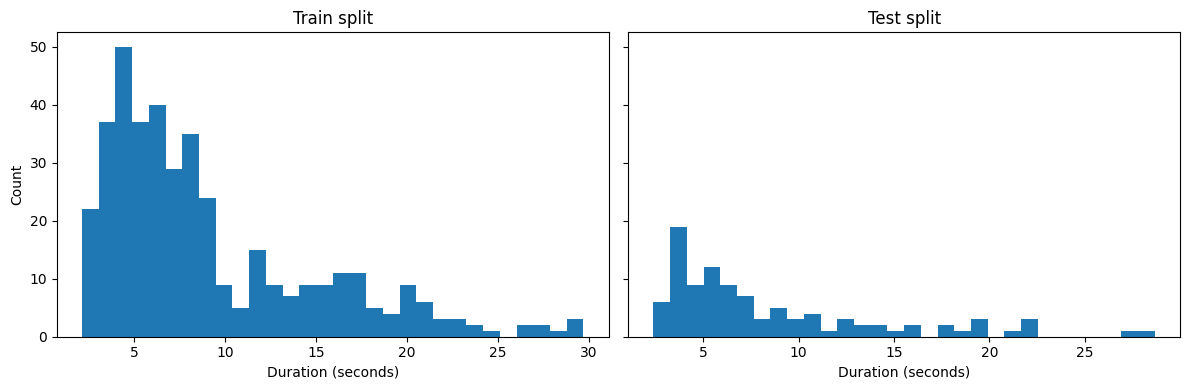

In [11]:
import matplotlib.pyplot as plt

durations = {}
for split in ["train","test"]:
    durations[split] = [
        ex["audio"]["array"].shape[0] / ex["audio"]["sampling_rate"]
        for ex in minds[split]
    ]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, split in zip(axes, ["train","test"]):
    ax.hist(durations[split], bins=30)
    ax.set_title(f"{split.capitalize()} split")
    ax.set_xlabel("Duration (seconds)")
axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()

結果圖已經出來了，看起來訓練組和測試組的音訊長度分佈不太一樣哦！

- **訓練組（Train split）**：大多數音訊集中在 0 到 10 秒左右，超過 20 秒的就很少見了。
- **測試組（Test split）**：音訊長度也多在 0 到 10 秒，但整體數量少很多，長度到 20 秒以上的就更稀疏了。

## 3.2 資料集準備：把資料轉成 Whisper 能用的格式

> 目標：把「原始音檔＋文字」一次性轉成 input_features（log-Mel）與 labels（token IDs），並定義 批次整理器（collator），讓 Trainer 能直接開跑。

在開始微調 Whisper 之前，我們得先把資料集整理成它喜歡的輸入格式！主要分成兩部分：

- `input_features`: 80 維的 log-Mel 聲譜圖框架。
- `labels`: 轉成 token 的目標轉錄內容。

將資料轉成 Whisper 可訓練的「模型就緒格式」（model-ready）

步驟總覽

| 階段               | 目的                                                 | 關鍵輸出                       | 對應程式段落                                 |
| ---------------- | -------------------------------------------------- | -------------------------- | -------------------------------------- |
| ① 統一音訊格式         | 確保所有音檔都是 16kHz、單聲道，方便後續特徵擷取                        | `audio["array"]`（標準化波形）    | `cast_column("audio", Audio(16000))`   |
| ② 特徵＋標籤轉換        | 將音訊轉成 Whisper 用的 **log-Mel 特徵**，並把文字轉成 token ID 標籤 | `input_features`, `labels` | `prepare_dataset()`                    |
| ③ 批次整理（collator） | 讓不同長度的音訊與文字在訓練中能一起被批次化（padding / masking）          | batch tensors              | `DataCollatorSpeechSeq2SeqWithPadding` |







### 3.2.1 先把音訊欄位統一規格（批次轉換資料）

現在我們要開始把資料轉換成批次，這樣 Whisper 才能好好消化！這步有三個小任務：

1. 用 `batch["audio"]` 載入音訊資料，並順便重採樣。就像之前說的，🤗 Datasets 會幫我們即時處理重採樣，超方便！
2. 用特徵擷取器把一維的音訊陣列轉成 log-Mel 聲譜圖特徵，這樣 Whisper 看得懂。
3. 用分詞器把錄音的文字轉成 ID，準備當標籤。

以下是程式碼，來看看怎麼做：

In [12]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")

def prepare_dataset(batch):
    # 載入並重採樣音訊資料，從 48kHz 轉成 16kHz
    audio = batch["audio"]

    # 從音訊陣列計算 log-Mel 輸入特徵
    batch["input_features"] = feature_extractor(
        audio["array"],
        sampling_rate=audio["sampling_rate"]).input_features[0]

    # 將目標文字編碼成標籤 ID
    batch["labels"] = tokenizer(batch["transcription"]).input_ids
    return batch

preprocessor_config.json: 0.00B [00:00, ?B/s]

我們可以用 dataset 的 .map 方法在所有訓練樣本上應用上述函數:


In [13]:
minds = minds.map(
    prepare_dataset,
    remove_columns=minds.column_names["train"],
    num_proc=4 # use num_proc to speed up mapping
    )

minds['train']

Map (num_proc=4):   0%|          | 0/400 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 400
})

> 額外提醒的是，目前 datasets 主要使用 torchaudio 和[librosa](https://librosa.org/doc/latest/index.html) 來進行音訊載入和重採樣。如果你自己自訂資料載入/取樣函數的話，你完全可以直接透過 "path" 欄位取得音訊檔案路徑而不用管 "audio" 欄位。

### 3.2.2 單筆樣本 → 模型就緒（features & labels）：定義資料整理

處理序列到序列語音模型的資料跟其他任務不太一樣，因為 `input_features` 和 `labels` 的處理方式不一樣哦！簡單說：

- `input_features` 要靠特徵提取器來處理。
- `labels` 則是由分詞器來搞定。

來看看怎麼一步步搞定這兩個部分吧！

- **執行步驟一：處理 `input_features`**
`input_features` 已經被填滿到 30 秒，並轉成固定維度的 log-Mel 聲譜圖了！現在我們只要把它轉成 PyTorch 張量就行。用特徵提取器的 `.pad` 方法超方便，直接設 `return_tensors=pt` 就能搞定，超省事！

- **執行步驟二：把 `labels` 填滿**
`labels` 之前還沒填滿，所以得先用分詞器的 `.pad` 方法，把序列填到這個 batch 裡最長的長度。接著把填充的部分換成 `-100`，這樣這些部分就不會算進損失裡了。最後把開頭的 SOT 拿掉，等訓練時再加回去，這樣安排對 Whisper 來說最順手！

In [14]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-tiny",
    language="chinese",
    task="transcribe")

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
            self,
            features: List[Dict[str, Union[List[int], torch.Tensor]]]
            ) -> Dict[str, torch.Tensor]:

        # 1) Pad 音訊特徵（inputs）
        input_feats = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_feats, return_tensors="pt")

        # 2) Pad 文字標註（labels）並遮蔽 padding
        label_feats = [{"input_ids": f["labels"]} for f in features]
        labels_padded = self.processor.tokenizer.pad(label_feats, return_tensors="pt")
        labels = labels_padded["input_ids"].masked_fill(
            labels_padded.attention_mask.ne(1), -100
        )

        batch["labels"] = labels
        return batch


我們初始化一下剛剛定義的資料整理器:

In [15]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)



---



#第四章、模型設置

## 4.1 拿到預訓練模型：輕鬆載入 Whisper

現在該輪到 Whisper 上場了！我們要用 16 位元（FP16）精度載入 `WhisperForConditionalGeneration` 模型，這樣可以省下不少 GPU 記憶體。還有一招是用 `attn_implementation="flash_attention_2"` 啟用 FlashAttention-2，讓自註意力機制跑得更快、記憶體用得更聰明（記得要用 FP16 或 BF16 哦！）。另外，設 `device_map="auto"` 會自動把模型層分給可用裝置，超方便！


In [ ]:
!pip install -q flash-attn --no-build-isolation

In [16]:
import torch
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-tiny",
    dtype=torch.float16,
    device_map="auto",
    #attn_implementation="flash_attention_2" # 記得要額外安裝才能使用且只支持 Ampere GPUs
)

載入後，我們使用 torchinfo.summary 來驗證模型的架構和參數數量。

In [17]:
!pip install --quiet torchinfo==1.8.0

In [18]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                             Param #
WhisperForConditionalGeneration                    --
├─WhisperModel: 1-1                                --
│    └─WhisperEncoder: 2-1                         --
│    │    └─Conv1d: 3-1                            92,544
│    │    └─Conv1d: 3-2                            442,752
│    │    └─Embedding: 3-3                         (576,000)
│    │    └─ModuleList: 3-4                        7,096,320
│    │    └─LayerNorm: 3-5                         768
│    └─WhisperDecoder: 2-2                         --
│    │    └─Embedding: 3-6                         19,916,160
│    │    └─WhisperPositionalEmbedding: 3-7        172,032
│    │    └─ModuleList: 3-8                        9,463,296
│    │    └─LayerNorm: 3-9                         768
├─Linear: 1-2                                      19,916,160
Total params: 57,676,800
Trainable params: 57,100,800
Non-trainable params: 576,000

## 4.2 定義評估指標：用 WER 來測驗 Whisper

接下來要設定一個評估工具啦！我們用單字錯誤率（WER）來檢查 Whisper 的表現，這可是評估語音辨識系統的「標準」指標哦！想知道更多細節？可以去 [WER 文件](https://huggingface.co/metrics/wer) 瞧瞧！

![](https://cdn.prod.website-files.com/645a730e85c9b4dfd57de5a1/66f6a936e28aa0b7f20aeb14_6645ebcf10fd5f613da195a2_WER-formula.webp)


In [19]:
!pip install --quiet evaluate==0.4.6
!pip install --quiet jiwer==4.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 51.0 MB/s eta 0:00:00


In [20]:
import evaluate

metric = evaluate.load("wer")

我們只需要定義一個函數來接受模型輸出並傳回 WER 指標。這個名為 `compute_metrics` 的函數首先將 -100 替換為 label_ids 中的 pad_token_id (以便在計算損失時將其忽略)。然後，將預測到的 ID 和 label_ids 解碼為字串文字。最後，計算輸出文字和真實文字之間的 WER:

In [21]:
def compute_metrics(pred):
    """
    計算單字錯誤率 (WER) 來評估模型預測。

    Args:
        pred: 訓練器輸出的預測結果，包含 predictions 和 label_ids。

    Returns:
        包含 WER 分數的字典。
    """
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # 把 -100 換成 pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # 不把 token 合併起來計算
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

- 抓取預測結果（pred_ids）和真實標籤（label_ids）。
- 把 -100 換成填充標籤，讓計算更乾淨。
- 把 token 轉成文字，然後算出 WER（單位是百分比）。
- 最後回傳 WER 分數，這樣我們就知道 Whisper 錯了多少字啦！

## 4.3 設定 LoRA 參數：讓 Whisper 更聰明又省力

現在要給 Whisper 裝個小幫手啦！我們用 PEFT 庫把 LoRA 適配器加到預訓練的 Whisper 模型上，讓它更好用。

> LoRA（“Low-Rank Adaptation”）會凍結原本的權重，只在特定層學一點低秩更新。這樣可訓練的參數變少，微調速度也快很多哦！

還有個好處，LoRA 的更新是單獨存的，你可以輕鬆換不同適配器檢查點，比如支援新語言或專業領域，底層模型還是不變！

來看看怎麼設定：

In [22]:
from peft import LoraConfig, get_peft_model, TaskType

# 設定 LoRA 用於序列到序列語言模型
lora_config = LoraConfig(
    r=8,                           # 低秩矩陣的秩
    lora_alpha=32,                 # LoRA 更新的縮放因子
    lora_dropout=0.1,              # LoRA 層的 dropout 機率
    target_modules=["q_proj", "v_proj"]  # 要適配的 Transformer 模組（可依需要調整）
)

# 有些模型預設會凍結嵌入層，這行確保 LoRA 能適配它們
model.enable_input_require_grads()

# 用 LoRA 適配器包裝模型，只讓 LoRA 參數可訓練
model = get_peft_model(model, lora_config)

# 可選：印出可訓練參數，確認只有 LoRA 層在更新
print("Trainable parameters after applying LoRA:")
model.print_trainable_parameters()

Trainable parameters after applying LoRA:
trainable params: 147,456 || all params: 37,908,096 || trainable%: 0.3890


##4.4-設定訓練參數

我們使用 Hugging Face 的 Seq2SeqTrainingArguments 來定義與訓練相關的所有參數

以下對其中一部分參數進行了解釋:

- output_dir : 保存模型權重的本機目錄，它也會是 Hugging Face Hub 上的模型儲存庫名稱。
- generation_max_length : 評估階段，自迴歸產生的最大詞元數。
- save_steps : 訓練期間，每 save_steps 步保存一次中間 checkpoint 並非同步上傳到 Hub。
- eval_steps : 訓練期間，每 eval_steps 步驟對中間 checkpoint 進行一次評估。
- report_to : 訓練日誌的保存位置，支援 azure_ml 、 comet_ml 、 mlflow 、 neptune 、 - tensorboard 以及 wandb 這些平台。你可以按照自己的偏好進行選擇，也可以直接使用缺省的 tensorboard 儲存至 Hub。



In [23]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="whisper-tiny-zh",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1, # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-3,
    warmup_steps=50,
    num_train_epochs=3,
    eval_strategy="epoch",
    fp16=True,
    per_device_eval_batch_size=16,
    generation_max_length=128, #
    logging_steps=25,
    remove_unused_columns=False,  #required for the PeftModel forward
    label_names=["labels"],  #same reason as above
    report_to=["none"],  # Disable logging
    )

我們可以將訓練參數以及模型、資料集、資料整理器和 compute_metrics 函數一起傳給🤗 Trainer:

In [24]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=minds["train"],
    eval_dataset=minds["test"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
)

/tmp/ipython-input-1135648257.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


##4.5-微調 Whisper 模型-泡茶的時刻

現在開始訓練過程。訓練器將使用 LoRA 適配器對模型進行微調。僅更新 LoRA 特定的參數。

> 我們正在使用 Whisper-tiny 模型進行演示，如果您想要生產品質的轉錄，請增加 Whisper 模型的大小並使用更大的資料集對其進行微調。

In [25]:
trainer.train()

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.922900,0.707653
2,0.595000,0.517054
3,0.381100,0.487190


TrainOutput(global_step=75, training_loss=0.9663175710042318, metrics={'train_runtime': 245.8355, 'train_samples_per_second': 4.881, 'train_steps_per_second': 0.305, 'total_flos': 2.9797466112e+16, 'train_loss': 0.9663175710042318, 'epoch': 3.0})

通常訓練會跑多久呢？

取決於你的 GPU 或 Google Colab 後端的 GPU。根據 GPU 的情況，你可能會在開始訓練時遇到 CUDA 内存耗尽錯誤。此時，你可以將 per_device_train_batch_size 逐次減少 2 倍，同時增加 gradient_accumulation_steps 進行補償。

###4.5.1-保存與上傳模型

將模型推送到您選擇的 Hugging Face Hub 儲存庫。

In [33]:
peft_model_id = f"{username}/" + f"whisper-tiny-LoRA".replace("/", "-")
model.push_to_hub(peft_model_id)
print(peft_model_id)

Heng666/whisper-tiny-LoRA


然後可以再拿回來使用

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import WhisperForConditionalGeneration

# Load the fine-tuned LoRA model from the Hugging Face Hub
peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path,
    torch_dtype=torch.float16,
    device_map="auto",
    #attn_implementation="flash_attention_2",
)
model = PeftModel.from_pretrained(model, peft_model_id)

##4.6-評估模型效果

在此步驟中，我們將 PEFT-LoRA 微調的 Whisper 模型與原始的「tiny」基礎模型進行比較，方法是在測試集上運行並計算其字錯誤率 (WER)。

In [26]:
from torch.utils.data import DataLoader

eval_dataloader = DataLoader(
    minds["test"],
    batch_size=16,
    collate_fn=data_collator)

先來讀取 Whisper同等級 tiny 模型

In [27]:
import torch
from transformers import WhisperForConditionalGeneration

tiny_model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-tiny",
    dtype=torch.float16,
    device_map="auto",
    #attn_implementation="flash_attention_2" # 記得要額外安裝才能使用且只支持 Ampere GPUs
)

建立評估方式

In [28]:
!pip install --quiet tqdm==4.67.1

In [29]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import gc
import evaluate

def evaluate_model(model, dataloader, tokenizer, model_name=None):
    """
    Evaluates a given model on a dataloader and computes the Word Error Rate (WER).
    """
    model.eval()
    metric = evaluate.load("wer")
    progress_bar = tqdm(dataloader, desc=f"Evaluating {model_name}")

    for batch in progress_bar:
        input_features = batch["input_features"].to(model.device, dtype=torch.float16)
        labels = batch["labels"].to(model.device)

        with torch.no_grad():
            prompt_ids = labels[:, :4]
            generated_tokens = model.generate(
                input_features=input_features,
                decoder_input_ids=prompt_ids,
            ).cpu().numpy()

            labels = labels.cpu().numpy()
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

            decoded_preds = tokenizer.batch_decode(
                generated_tokens,
                skip_special_tokens=True)

            decoded_labels = tokenizer.batch_decode(
                labels,
                skip_special_tokens=True)

            metric.add_batch(predictions=decoded_preds, references=decoded_labels)

        gc.collect()
        torch.cuda.empty_cache()

    wer = 100 * metric.compute()
    return wer

In [31]:
#Evaluate the models to get the WER scores
lora_model_wer = evaluate_model(
    model,
    eval_dataloader,
    tokenizer,
    model_name="Fine-tuned Whisper tiny with LoRA")

tiny_model_wer = evaluate_model(
    tiny_model,
    eval_dataloader,
    tokenizer,
    model_name="Whisper tiny")

results_data = {
    "Model": ["Whisper tiny", "Fine-tuned Whisper tiny with LoRA"],
    "WER (%)": [tiny_model_wer, lora_model_wer]
}

results_df = pd.DataFrame(results_data)

print("\n--- Evaluation Results ---")
print(results_df.to_string(index=False))
improvement = tiny_model_wer - lora_model_wer
print(f"\nThe fine-tuned LoRA model shows an improvement of {improvement:.2f} WER points over the base model.")

Evaluating Fine-tuned Whisper tiny with LoRA:   0%|          | 0/7 [00:00<?, ?it/s]Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating Whisper tiny: 100%|██████████| 7/7 [00:26<00:00,  3.74s/it]


--- Evaluation Results ---
                            Model    WER (%)
                     Whisper tiny 111.111111
Fine-tuned Whisper tiny with LoRA  73.504274

The fine-tuned LoRA model shows an improvement of 37.61 WER points over the base model.


#第五章、建造示範空間

##5.1-建造 Gradio 進行示範
在這裡，我們建立了一個簡單的 Web 介面，以便使用者可以對著麥克風說話並查看來自我們的 PEFT-LoRA Whisper 模型的即時轉錄。

In [34]:
import torch
import gradio as gr
from transformers import (
    AutomaticSpeechRecognitionPipeline,
    WhisperForConditionalGeneration,
    WhisperTokenizer,
    WhisperProcessor,
)
from peft import PeftModel, PeftConfig

peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path,
    torch_dtype=torch.float16,
    device_map="auto",
    # attn_implementation="flash_attention_2",
)
model = PeftModel.from_pretrained(model, peft_model_id)

tokenizer = WhisperTokenizer.from_pretrained(
    peft_config.base_model_name_or_path,
    language="zh",
    task="transcribe")

processor = WhisperProcessor.from_pretrained(
    peft_config.base_model_name_or_path,
    language="zh",
    task="transcribe")

feature_extractor = processor.feature_extractor
forced_decoder_ids = processor.get_decoder_prompt_ids(
    language="zh",
    task="transcribe")

pipe = AutomaticSpeechRecognitionPipeline(
    model=model,
    tokenizer=tokenizer,
    feature_extractor=feature_extractor)


def transcribe(audio):
    with torch.amp.autocast(device_type="cuda"):
        text = pipe(
            audio,
            generate_kwargs={"forced_decoder_ids": forced_decoder_ids})["text"]
    return text

with gr.Blocks(css="""
    .banner { display:flex; flex-direction:column; align-items:center; margin-bottom:20px; }
    .banner img { max-width:250px; width:100%; height:auto; }
    body { background-color: #f7f7f7; }
""") as demo:

    # Banner
    gr.HTML("""
    <div class="banner">
      <h1>PEFT LoRA Whisper Demo</h1>
    </div>
    """)

    # Description
    gr.Markdown(
      "**中文語音轉文字示範**  \n"
      "請使用下方麥克風錄音，測試我們使用 LoRA 微調過的 Whisper（Tiny）模型，"
      "看看它在處理中文語音上的表現。"
      "\n此範例僅供展示，如需更精準的結果，建議使用更大型的 Whisper 模型進行微調。"
    )

    audio_in = gr.Audio(sources=["microphone"], type="filepath", label="Record your audio")
    text_out = gr.Textbox(label="Transcription")

    btn = gr.Button("Transcribe")
    btn.click(fn=transcribe, inputs=audio_in, outputs=text_out)

demo.launch(share=True, debug=True)

adapter_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


adapter_model.safetensors:   0%|          | 0.00/596k [00:00<?, ?B/s]

Device set to use cuda:0


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a35e9a6563abd06d4f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a35e9a6563abd06d4f.gradio.live
